In [43]:
import numpy as np
import gymnasium as gym
from matplotlib import pyplot as plt

In [44]:
# Cell 2: Q-Learning Agent and Helper Functions

"""

Creating the frozen lake environment using gymnasium

there are 2 different maps, one for the 4x4 and one for the 8x8 grid. You can also create a custom map by changing the description parameter to a list of strings.

S = starting point, safe
F = floor, safe
H = spill pits, terminal, no reward
G = target shelf goal, terminal, reward +1

4x4 map:
S F F F
F H F H
F F F H
H F F G

8x8 map:
S F F F F F F F
F F F F F F F F
F F F H F F F F
F F F F F H F F
F F F H F F F F
F H H F F F H F
F H F F H F H F
F F F H F F F G

"""

class FrozenLakeAgent:
    def __init__(
        self,
        env: gym.Env,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float,
    ):
        """Creates a Q-learning agent for the Frozen Lake environment."""
        self.env = env
        self.q_table = np.zeros((env.observation_space.n, env.action_space.n))
        self.lr = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.training_error = []
    
    def get_action(self, obs: int) -> int:
        """Choose an action using the epsilon-greedy strategy."""
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.q_table[obs])

    def update(
        self, 
        obs: int,
        action: int,
        reward: float,
        terminated: bool,
        next_obs: int,
    ):
        """Update the Q-value based on experience."""
        current_q = self.q_table[obs][action]
        max_future_q = np.max(self.q_table[next_obs]) if not terminated else 0
        
        # Q-learning formula (Temporal Difference Update)
        new_q = (1 - self.lr) * current_q + self.lr * (reward + self.discount_factor * max_future_q)

        self.q_table[obs][action] = new_q
        self.training_error.append(abs(new_q - current_q))

    def decay_epsilon(self):
        """Decay epsilon after each episode."""
        self.epsilon = max(self.final_epsilon, self.epsilon * self.epsilon_decay)


def evaluate_trained_agent(agent, env, num_episodes=1000):
    """Evaluate the trained Q-learning agent without exploration."""
    successes = 0
    for _ in range(num_episodes):
        obs, _ = env.reset()
        done = False
        while not done:
            action = np.argmax(agent.q_table[obs])
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            if done and reward > 0:
                successes += 1
    success_rate = successes / num_episodes
    print(f"Q-learning Agent Success Rate: {success_rate:.3f} ({success_rate*100:.1f}%)")
    return success_rate

def evaluate_random_baseline(env, num_episodes=1000):
    """Evaluate random policy baseline."""
    successes = 0
    for _ in range(num_episodes):
        obs, _ = env.reset()
        done = False
        steps = 0
        while not done and steps < 200:
            action = env.action_space.sample()
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            steps += 1
            if done and reward > 0:
                successes += 1
    success_rate = successes / num_episodes
    print(f"Random Policy Success Rate: {success_rate:.3f} ({success_rate*100:.1f}%)")
    return success_rate

def evaluate_heuristic_baseline(env, num_episodes=1000):
    """Evaluate simple heuristic baseline (always try down/right)."""
    successes = 0
    for episode in range(num_episodes):
        obs, _ = env.reset()
        done = False
        steps = 0
        while not done and steps < 200:
            action = 1 if steps % 2 == 0 else 2 # Down (1) or Right (2)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            steps += 1
            if done and reward > 0:
                successes += 1
    success_rate = successes / num_episodes
    print(f"Heuristic Policy Success Rate: {success_rate:.3f} ({success_rate*100:.1f}%)")
    return success_rate

def get_moving_avgs(arr, window, convolution_mode):
    """Compute moving average to smooth noisy data."""
    return np.convolve(
        np.array(arr).flatten(),
        np.ones(window),
        mode=convolution_mode
    ) / window

In [ ]:
# Cell 3: The Core Experiment Function

def run_experiment(map_name: str, map_config: dict, training_params: dict, agent_params: dict = None):
    """
    Initializes the environment, trains the agent, plots results, and evaluates performance.

    Args:
        map_name: Gym map name (e.g., '4x4' or '8x8')
        map_config: kwargs for gym.make (is_slippery, success_rate, ...)
        training_params: dict containing training-level params, must include 'EPISODES'
        agent_params: dict with agent hyperparameters (learning_rate, discount_factor,
                      initial_epsilon, final_epsilon, epsilon_decay). If None, the function
                      will attempt to extract these from training_params.

    Returns:
        final_success_rate (float)
    """
    print(f"\n{'='*50}\nSTARTING EXPERIMENT FOR MAP: {map_name}\n{'='*50}")

    # 1. Environment Setup
    env = gym.make("FrozenLake-v1", map_name=map_name, **map_config)

    # Determine agent parameters (backwards-compatible: extract from training_params if needed)
    if agent_params is None:
        required_agent_keys = ['learning_rate', 'discount_factor', 'initial_epsilon', 'final_epsilon', 'epsilon_decay']
        try:
            agent_params = {k: training_params[k] for k in required_agent_keys}
        except KeyError:
            raise ValueError("agent_params must be provided or training_params must contain required agent keys")

    # 2. Agent Initialization
    agent = FrozenLakeAgent(env=env, **agent_params)
    
    # 3. Training Loop
    episode_rewards = []
    episode_lengths = []

    episodes = int(training_params.get('EPISODES', 1000))
    print(f"Starting training for {episodes} episodes...")

    # Decide how many progress prints to show (up to 10 evenly spaced)
    progress_updates = min(10, max(1, episodes // 100))
    update_interval = max(1, episodes // progress_updates)

    for episode in range(episodes):
        obs, info = env.reset()
        done = False
        episode_reward = 0
        episode_length = 0

        while not done:
            action = agent.get_action(obs)
            next_obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            agent.update(obs, action, reward, terminated, next_obs)

            episode_reward += reward
            episode_length += 1
            obs = next_obs

        agent.decay_epsilon()

        episode_rewards.append(episode_reward)
        episode_lengths.append(episode_length)

        # Print periodic progress: show `progress_updates` evenly-spaced updates
        if (episode + 1) % update_interval == 0 or (episode + 1) == episodes:
            recent_window = min(1000, max(10, episodes // 20))
            recent_window = min(recent_window, len(episode_rewards))
            recent_success = sum(episode_rewards[-recent_window:]) / max(1, recent_window)
            print(f"Episode {episode + 1}: Recent success (last {recent_window}) = {recent_success:.3f}")

    print("Training completed!")

    # 4. Visualization
    rolling_length = min(500, max(1, episodes // 20))
    fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

    fig.suptitle(f"Q-Learning Progress on {map_name} Map", fontsize=16)

    # Episode rewards
    axs[0].set_title("Episode rewards")
    reward_moving_average = get_moving_avgs(episode_rewards, rolling_length, "valid")
    axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
    axs[0].set_ylabel("Average Reward")
    axs[0].set_xlabel("Episode")

    # Episode lengths
    axs[1].set_title("Episode lengths")
    length_moving_average = get_moving_avgs(episode_lengths, rolling_length, "valid")
    axs[1].plot(range(len(length_moving_average)), length_moving_average)
    axs[1].set_ylabel("Average Episode Length")
    axs[1].set_xlabel("Episode")

    # Training error
    axs[2].set_title("Training Error")
    training_error_moving_average = get_moving_avgs(agent.training_error, rolling_length, "same")
    axs[2].plot(range(len(agent.training_error)), training_error_moving_average)
    axs[2].set_ylabel("Temporal Difference Error")
    axs[2].set_xlabel("Step")

    plt.tight_layout()
    plt.show()

    # 5. Evaluation and Comparison
    print("\n FINAL EVALUATION & BASELINE COMPARISON")
    print("="*60)
    final_success_rate = evaluate_trained_agent(agent, env, num_episodes=1000)

    print("\n BASELINE COMPARISONS")
    print("="*50)
    random_success = evaluate_random_baseline(env, num_episodes=1000)
    heuristic_success = evaluate_heuristic_baseline(env, num_episodes=1000)

    print("\n PERFORMANCE SUMMARY") 
    print("="*50)
    print(f"Q-learning Agent: {final_success_rate:.3f} ({final_success_rate*100:.1f}%)")
    print(f"Random Baseline: {random_success:.3f} ({random_success*100:.1f}%)")
    print(f"Heuristic Baseline: {heuristic_success:.3f} ({heuristic_success*100:.1f}%)")
    
    if random_success > 0:
        print(f"Improvement over Random: {final_success_rate/random_success:.1f}x better")
    if heuristic_success > 0:
        print(f"Improvement over Heuristic: {final_success_rate/heuristic_success:.1f}x better")
    
    print("\n Q-TABLE ANALYSIS")
    print("="*30)
    print(agent.q_table)

    env.close()
    return final_success_rate



--- Running 4x4 Experiment ---

STARTING EXPERIMENT FOR MAP: 4x4
Starting training for 20000 episodes...
Episode 10000: Avg. Success rate (last 1000) = 0.186
Episode 20000: Avg. Success rate (last 1000) = 0.504
Training completed!


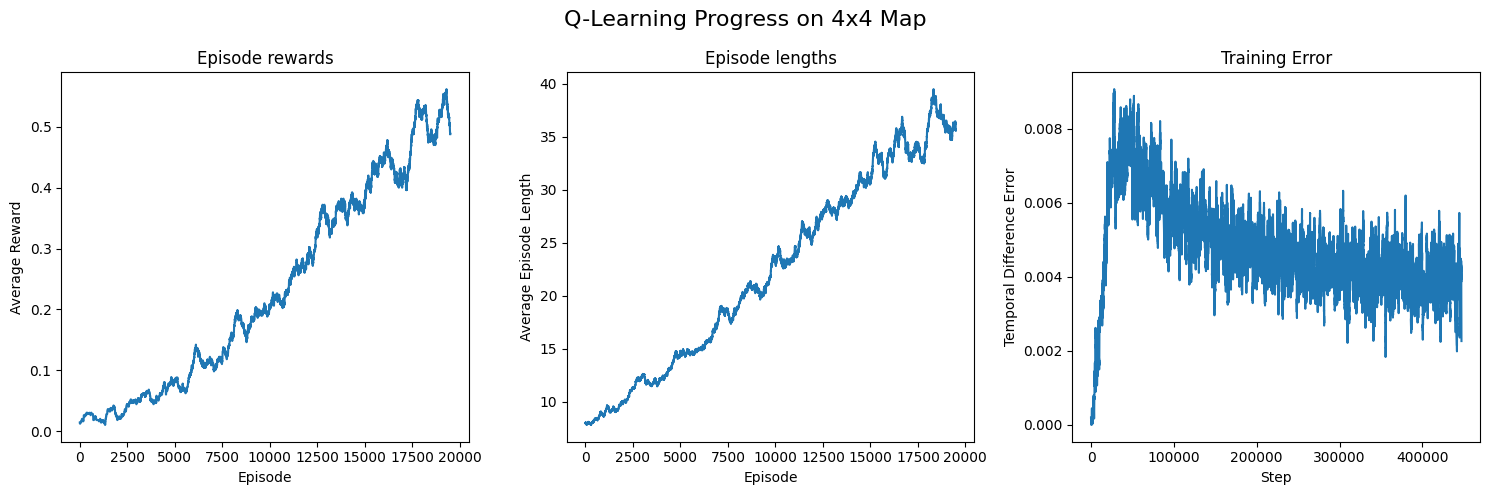


 FINAL EVALUATION & BASELINE COMPARISON
Q-learning Agent Success Rate: 0.729 (72.9%)

 BASELINE COMPARISONS
Random Policy Success Rate: 0.011 (1.1%)
Heuristic Policy Success Rate: 0.042 (4.2%)

 PERFORMANCE SUMMARY
Q-learning Agent: 0.729 (72.9%)
Random Baseline: 0.011 (1.1%)
Heuristic Baseline: 0.042 (4.2%)
Improvement over Random: 66.3x better
Improvement over Heuristic: 17.4x better

 Q-TABLE ANALYSIS
[[0.46238033 0.45503456 0.45734537 0.45474623]
 [0.27431095 0.28963664 0.38961362 0.44209592]
 [0.41389916 0.40877373 0.40732387 0.42843593]
 [0.25506246 0.26146628 0.25638598 0.42322517]
 [0.47106759 0.33497046 0.39075093 0.33503873]
 [0.         0.         0.         0.        ]
 [0.16050645 0.12721862 0.24173153 0.15924117]
 [0.         0.         0.         0.        ]
 [0.38097765 0.45974432 0.34082992 0.49090331]
 [0.45817881 0.57294881 0.48488249 0.27045601]
 [0.46956704 0.37026174 0.36063604 0.28581237]
 [0.         0.         0.         0.        ]
 [0.         0.         0. 

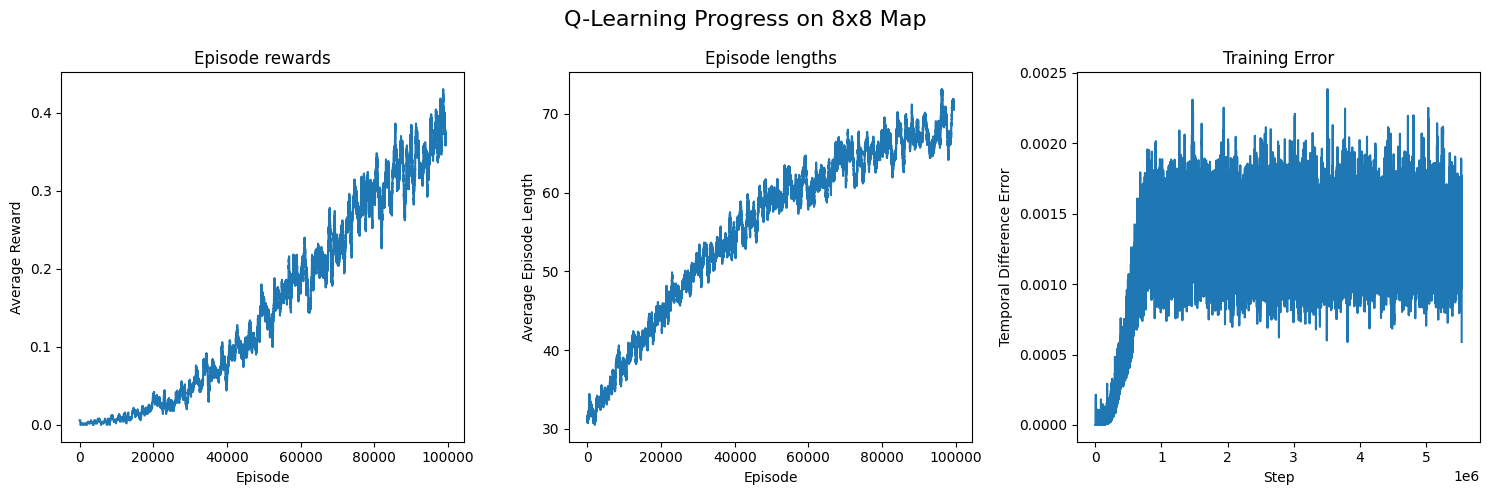


 FINAL EVALUATION & BASELINE COMPARISON
Q-learning Agent Success Rate: 0.643 (64.3%)

 BASELINE COMPARISONS
Q-learning Agent Success Rate: 0.643 (64.3%)

 BASELINE COMPARISONS
Random Policy Success Rate: 0.001 (0.1%)
Heuristic Policy Success Rate: 0.017 (1.7%)

 PERFORMANCE SUMMARY
Q-learning Agent: 0.643 (64.3%)
Random Baseline: 0.001 (0.1%)
Heuristic Baseline: 0.017 (1.7%)
Improvement over Random: 643.0x better
Improvement over Heuristic: 37.8x better

 Q-TABLE ANALYSIS
[[0.4043678  0.40543364 0.40519715 0.40897123]
 [0.41359816 0.41570561 0.41921536 0.41516291]
 [0.42994233 0.43150617 0.4444469  0.43318914]
 [0.45049741 0.45612216 0.46274163 0.45620225]
 [0.48085661 0.48054548 0.49614943 0.4824591 ]
 [0.50377236 0.50387508 0.52209538 0.50459009]
 [0.52452173 0.52778372 0.54809319 0.52775432]
 [0.53464721 0.53254702 0.5544738  0.53011849]
 [0.40230435 0.402656   0.40353019 0.40320505]
 [0.40862703 0.41030914 0.40894613 0.41367927]
 [0.4201745  0.42049653 0.42654624 0.43442523]
 [0.3

In [46]:
# Cell 4: Configuration and Sequential Execution (Final, Corrected Logic)

# --- GLOBAL ENVIRONMENT CONFIG ---
COMMON_ENV_CONFIG = {
    "is_slippery": True, 
    "success_rate": 1.0/3.0,
    "reward_schedule": (1, 0, 0) # Goal, Hole, Frozen (Sparse Reward)
}

# --- HYPERPARAMETERS ---
# Parameters optimized for the difficulty of each map

# 4x4 is easier, can decay faster, needs fewer steps
P_4X4 = {
    'EPISODES': 20000, 
    'learning_rate': 0.1, 
    'discount_factor': 0.99, 
    'initial_epsilon': 1.0, 
    'final_epsilon': 0.05, 
    # Decay to reach 0.05 at 20k episodes
    'epsilon_decay': 0.99985
}

# 8x8 is much harder, needs more steps and slower decay
P_8X8 = {
    'EPISODES': 100000, 
    'learning_rate': 0.05, 
    'discount_factor': 0.99, 
    'initial_epsilon': 1.0, 
    'final_epsilon': 0.1, 
    # Decay to reach 0.1 at 100k episodes
    'epsilon_decay': 0.999977
}

def get_agent_params(all_params):
    """Extracts only the required hyperparameters for the FrozenLakeAgent constructor."""
    return {
        'learning_rate': all_params['learning_rate'],
        'discount_factor': all_params['discount_factor'],
        'initial_epsilon': all_params['initial_epsilon'],
        'final_epsilon': all_params['final_epsilon'],
        'epsilon_decay': all_params['epsilon_decay'],
    }

# --- RUN EXPERIMENTS ---

# Run 1: 4x4 Map (Restored and Corrected)
print("\n--- Running 4x4 Experiment ---")
agent_params_4x4 = get_agent_params(P_4X4) # Extract required keys
final_rate_4x4 = run_experiment("4x4", COMMON_ENV_CONFIG, P_4X4, agent_params_4x4)

# Run 2: 8x8 Map (Corrected)
print("\n--- Running 8x8 Experiment ---")
agent_params_8x8 = get_agent_params(P_8X8) # Extract required keys
final_rate_8x8 = run_experiment("8x8", COMMON_ENV_CONFIG, P_8X8, agent_params_8x8)

# --- FINAL COMPARISON ---
# Both final_rate_4x4 and final_rate_8x8 are now defined
print("\n\n--- FINAL EXPERIMENT RESULTS ---")
print(f"4x4 Map Final Success Rate: {final_rate_4x4:.3f}")
print(f"8x8 Map Final Success Rate: {final_rate_8x8:.3f}")